In [1]:
import sqlite3
import pandas as pd
from random import sample
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('../data/trip_data.db')

In [3]:
q_license = """
SELECT distinct(hack_license) as UNIQ_LIC
FROM trip
"""

unique_license = pd.read_sql(q_license, conn)

In [4]:
LIC_SAMPLE_NUM = 5000
sampled_drivers = sample(unique_license.UNIQ_LIC.tolist(), LIC_SAMPLE_NUM)

In [5]:
q_sample = """
SELECT *, 
        lag(pickup_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as pickup_datetime_next,
        lag(dropoff_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as dropoff_datetime_next
    FROM trip
    WHERE hack_license in {0}
ORDER BY hack_license ASC, pickup_datetime ASC, dropoff_datetime ASC
"""

sampled_trip = pd.read_sql(q_sample.format(tuple(sampled_drivers)), conn)

In [6]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next
0,2013002341,2013000002,CMT,1,2013-06-01 00:00:48,2013-06-01 00:08:49,4,481,1.7,-73.958466,40.775555,-73.978134,40.764900,2013-06-01 00:10:31,2013-06-01 00:23:14
1,2013002341,2013000002,CMT,1,2013-06-01 00:10:31,2013-06-01 00:23:14,1,762,7.1,-73.979721,40.765530,-73.940567,40.847885,2013-06-01 00:37:29,2013-06-01 00:45:58
2,2013002341,2013000002,CMT,1,2013-06-01 00:37:29,2013-06-01 00:45:58,2,508,2.0,-73.971413,40.795551,-73.984253,40.772579,2013-06-01 00:48:44,2013-06-01 01:20:25
3,2013002341,2013000002,CMT,1,2013-06-01 00:48:44,2013-06-01 01:20:25,1,1900,8.1,-73.987518,40.770538,-73.942558,40.714706,2013-06-01 01:22:21,2013-06-01 01:26:51
4,2013002341,2013000002,CMT,1,2013-06-01 01:22:21,2013-06-01 01:26:51,4,270,1.0,-73.942490,40.714649,-73.937012,40.701691,2013-06-01 01:42:51,2013-06-01 01:45:21


In [7]:
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])
sampled_trip['delta'] = (sampled_trip['pickup_datetime_next'] - sampled_trip['dropoff_datetime']) / pd.Timedelta(hours=1)

In [8]:
k=5

## If delta > k, the trip is the last drop off of the shift
## And the next trip of the driver is the first pickup (shifted)
sampled_trip['last_dropoff'] = [1 if d > k else 0 for d in sampled_trip['delta']]
sampled_trip['first_pickup'] = sampled_trip.groupby('hack_license')['last_dropoff'].shift(1)
sampled_trip.dropna(subset=['pickup_datetime_next', 'dropoff_datetime_next'], inplace=True) 
sampled_trip['first_pickup'].fillna(0, inplace=True)

In [9]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,delta,last_dropoff,first_pickup
0,2013002341,2013000002,CMT,1,2013-06-01 00:00:48,2013-06-01 00:08:49,4,481,1.7,-73.958466,40.775555,-73.978134,40.764900,2013-06-01 00:10:31,2013-06-01 00:23:14,0.028333,0,0.0
1,2013002341,2013000002,CMT,1,2013-06-01 00:10:31,2013-06-01 00:23:14,1,762,7.1,-73.979721,40.765530,-73.940567,40.847885,2013-06-01 00:37:29,2013-06-01 00:45:58,0.237500,0,0.0
2,2013002341,2013000002,CMT,1,2013-06-01 00:37:29,2013-06-01 00:45:58,2,508,2.0,-73.971413,40.795551,-73.984253,40.772579,2013-06-01 00:48:44,2013-06-01 01:20:25,0.046111,0,0.0
3,2013002341,2013000002,CMT,1,2013-06-01 00:48:44,2013-06-01 01:20:25,1,1900,8.1,-73.987518,40.770538,-73.942558,40.714706,2013-06-01 01:22:21,2013-06-01 01:26:51,0.032222,0,0.0
4,2013002341,2013000002,CMT,1,2013-06-01 01:22:21,2013-06-01 01:26:51,4,270,1.0,-73.942490,40.714649,-73.937012,40.701691,2013-06-01 01:42:51,2013-06-01 01:45:21,0.266667,0,0.0


In [10]:
## Extract hour and day
sampled_trip['dropoff_hour'] = sampled_trip.dropoff_datetime.dt.hour
sampled_trip['pickup_hour'] = sampled_trip.pickup_datetime.dt.hour
sampled_trip['dropoff_day'] = sampled_trip.dropoff_datetime.dt.date
sampled_trip['pickup_day'] = sampled_trip.pickup_datetime.dt.date
sampled_trip['pickup_weekday'] = (sampled_trip.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 1).astype(int)
sampled_trip['dropoff_weekday'] = (sampled_trip.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 1).astype(int)


In [11]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_datetime_next,delta,last_dropoff,first_pickup,dropoff_hour,pickup_hour,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013002341,2013000002,CMT,1,2013-06-01 00:00:48,2013-06-01 00:08:49,4,481,1.7,-73.958466,...,2013-06-01 00:23:14,0.028333,0,0.0,0,0,2013-06-01,2013-06-01,1,1
1,2013002341,2013000002,CMT,1,2013-06-01 00:10:31,2013-06-01 00:23:14,1,762,7.1,-73.979721,...,2013-06-01 00:45:58,0.237500,0,0.0,0,0,2013-06-01,2013-06-01,1,1
2,2013002341,2013000002,CMT,1,2013-06-01 00:37:29,2013-06-01 00:45:58,2,508,2.0,-73.971413,...,2013-06-01 01:20:25,0.046111,0,0.0,0,0,2013-06-01,2013-06-01,1,1
3,2013002341,2013000002,CMT,1,2013-06-01 00:48:44,2013-06-01 01:20:25,1,1900,8.1,-73.987518,...,2013-06-01 01:26:51,0.032222,0,0.0,1,0,2013-06-01,2013-06-01,1,1
4,2013002341,2013000002,CMT,1,2013-06-01 01:22:21,2013-06-01 01:26:51,4,270,1.0,-73.942490,...,2013-06-01 01:45:21,0.266667,0,0.0,1,1,2013-06-01,2013-06-01,1,1


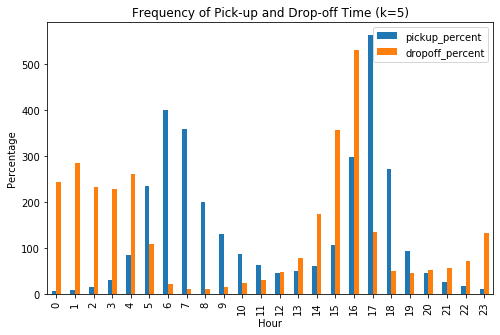

In [12]:
## Compute percentage

pickup_df = sampled_trip.loc[sampled_trip['first_pickup'] == 1]
pickup_per = pickup_df.groupby(['pickup_day', 'pickup_hour', 'pickup_weekday'])['pickup_hour'].count()
# pickup_per = pickup_per.groupby('pickup_day').apply(lambda x: x / x.sum() * 100)
pickup_per = pd.DataFrame(pickup_per).rename(columns={'pickup_hour':'pickup_percent'}).reset_index().\
                                        rename(columns={'pickup_day':'date',
                                                        'pickup_hour':'hour',
                                                           'pickup_weekday': 'weekday'})

dropoff_df = sampled_trip.loc[sampled_trip['last_dropoff'] == 1]
dropoff_per = dropoff_df.groupby(['dropoff_day', 'dropoff_hour', 'dropoff_weekday'])['dropoff_hour'].count()
# dropoff_per = dropoff_per.groupby('dropoff_day').apply(lambda x: x / x.sum() * 100)
dropoff_per = pd.DataFrame(dropoff_per).rename(columns={'dropoff_hour':'dropoff_percent'}).reset_index().\
                                        rename(columns={'dropoff_day':'date',
                                                        'dropoff_hour':'hour',
                                                           'dropoff_weekday': 'weekday'})

pick_drop_per = pickup_per.merge(dropoff_per)
pick_drop_per.head()


# % of Pick-up and Drop-off Time
pick_drop_per_all = pick_drop_per.groupby(['hour'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(figsize = (8,5))
pick_drop_per_all.plot(kind='bar',ax=ax);
ax.set_xlabel('Hour');
ax.set_ylabel('Percentage');
ax.set_title('Frequency of Pick-up and Drop-off Time (k={})'.format(k));
ax.legend();

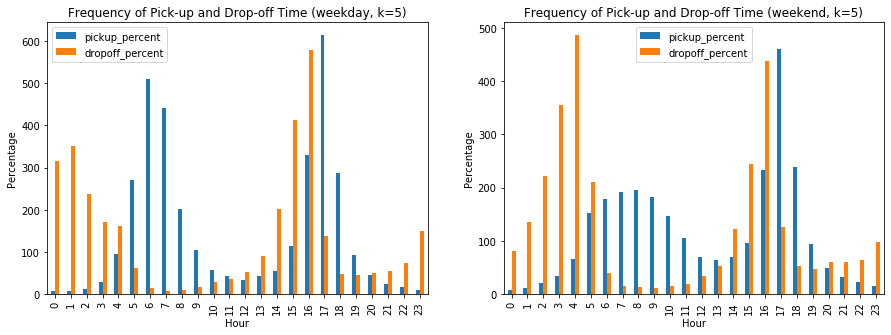

In [13]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
pick_drop_per_wk = pick_drop_per.groupby(['hour','weekday'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(1,2,figsize = (15,5))
pick_drop_per_wk[pick_drop_per_wk.weekday == 0].drop('weekday',axis=1).plot(kind='bar',ax=ax[0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 1].drop('weekday',axis=1).plot(kind='bar',ax=ax[1]);
ax[0].set_xlabel('Hour');
ax[0].set_ylabel('Percentage');
ax[0].set_title('Frequency of Pick-up and Drop-off Time (weekday, k={})'.format(k));
ax[0].legend();

ax[1].set_xlabel('Hour');
ax[1].set_ylabel('Percentage');
ax[1].set_title('Frequency of Pick-up and Drop-off Time (weekend, k={})'.format(k));
ax[1].legend()